In [1]:
import itertools
import numpy as np 
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

- One of the benefits of using TensorFlow is that it can keep track of it's operations and automatically update model variables
- Let's see how to change our model variables in such a way that loss function is minimized 
- Backpropogate errors through our computational graph to update our variable and minimize the loss function, this is done by declaring an optimize function 

In [2]:
sess = tf.Session()

In [3]:
# Function to create Confusion Matrix taken from scikit-learn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Loading the MNIST Dataset and uses One Hot encoding

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../Data/MNIST_data/",one_hot=True)

Extracting ../Data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../Data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../Data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../Data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# Splits the Train and Test data in percentage from using test_size parameters in this case 20% is used as Test data
from sklearn.model_selection import train_test_split
X_train,x_test,Y_train,y_test = train_test_split(mnist.train.images,mnist.train.labels,test_size=0.2)
print("Number of Training data: ", len(X_train))
print("Number of Test data:", len(x_test))

Number of Training data:  44000
Number of Test data: 11000


In [6]:
# The actual data break up and a sample encoded version of label
print(len(mnist.train.images))
print(len(mnist.test.images))
print(len(mnist.validation.images))
print(mnist.train.labels[1,:])

55000
10000
5000
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [7]:
# Optimization variables 
learning_rate = 0.5
epochs = 20
batch_size = 100
hidden_layer_nodes = 300

In [8]:
# Declaring the training data placeholder
# input x - for 28 X 28 pixels = 784

x = tf.placeholder(tf.float32, shape = [None,784])

# Declare the output data placeholder - 10 digits

y = tf.placeholder(tf.float32, [None, 10])

For below Code
- first we declare variables w1 and b1 the weights and bias for connection between input and hidden layer
- The hidden neural network has about 300 (default) layers of nodes 
- Therefore the size of weight 1 tensor is [784 - Rows, 300 - Cols]
- We initialized the value of weights using random normal distribution with mean of zero and stddev of 0.03
- Like wise we created W2 and b2 with 10 output nodes 

In [9]:
# Setting up Weights and Bias variable for Three layer Neural Network
# There are always L-1 number of weights and Bias tensors where L is the number of Layers 

# Declaring weights and Bias connecting the input to the Hidden Layer 
W1 = tf.Variable(tf.random_normal([784, hidden_layer_nodes], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([hidden_layer_nodes]), name= 'b1')

# and the weights connecting the Hidden Layer to the ouput layer
W2 = tf.Variable(tf.random_normal([hidden_layer_nodes,10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name= 'b2')

- First we'll execute the standard Matrix multiplication of inputs with weights 1 and add bias b1 to it
- net_worth = (Ax + b)
- Then we apply the activation function (ReLU Rectified Linear Unit) to the net_worth
- activation_function(net_worth)

In [10]:
# Next we setup the node inputs and and activation function for the hidden layer 
# Calculate the output of the Hidden Layer 

# [ ASSIGNMENT PROBLEM ]
# The activation function for Hidden Layer should either RELU or Sigmoid 

hidden_out_net = tf.add(tf.matmul(x,W1), b1)
hidden_out = tf.nn.relu(hidden_out_net)
#hidden_out = tf.nn.sigmoid(hidden_out_net)

In [11]:
# Now we set up the output layer 
# The output from the Hidden layer is the input to the Output Layer 
# We'll use the softmax activation function for the Output 
# [ASSIGNMENT PROBLEM] Activation function should be either Softmax or Sigmoid 

output_layer_net = tf.add(tf.matmul(hidden_out, W2), b2)
y_output = tf.nn.softmax(output_layer_net)
# y_output = tf.nn.sigmoid(output_layer_net)

- we have to include a cost function or loss function for the Optimization / Backpropogation to work on
- we'll be using Cross Entropy 
- The first line is a operation converting the output y_output to a clipped version limited between 1e-10 and 0.999999
- This is to ensure we never get a case where we have log(0) operation occuring during training as it would return NaN and break the training 

In [12]:
y_clipped = tf.clip_by_value(y_output, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped) + (1 - y) * tf.log(1 - y_clipped), axis=1))

In [13]:
# Setting up an optimizer

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [14]:
# setting up initialization operator 

init_op = tf.global_variables_initializer()

# Define an accuracy assesment model
# tf.equal returns True or False tf.argmax same as np.argmax returns the index of maximum value in a vector/tensor
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [15]:
y_output_arg = tf.argmax(y_output,1)

In [16]:
# This function calculates the error rate at each epoch 
def calculate_error_rate(pred_label, true_label):
    error_arg = true_label - pred_label 
    print("Error cal: ", error_arg)
    
    cnt_nonzeroes = np.count_nonzero(error_arg)
    cnt_zeroes = len(true_label) - cnt_nonzeroes
    error_percent = (cnt_nonzeroes / (cnt_zeroes + cnt_nonzeroes)) * 100
    print("Percentage error for one epoch :", error_percent)

In [17]:
# confusion_matrix = tf.confusion_matrix(labels=y, predictions=y_output, num_classes=10)
avg_cost_lst = []
class_names = np.arange(0,10)

In [18]:
sess.run(init_op)

Epoch: 1 cost= 0.661
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 4.58
Epoch: 2 cost= 0.237
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 3.19
Epoch: 3 cost= 0.177
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 3.2099999999999995
Epoch: 4 cost= 0.139
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 2.73
Epoch: 5 cost= 0.113
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 2.71
Epoch: 6 cost= 0.100
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 2.6
Epoch: 7 cost= 0.085
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 2.52
Epoch: 8 cost= 0.069
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 2.62
Epoch: 9 cost= 0.058
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 2.41
Epoch: 10 cost= 0.052
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 2.52
Epoch: 11 cost= 0.042
Error cal:  [0 0 0 ..., 0 0 0]
Percentage error for one epoch : 

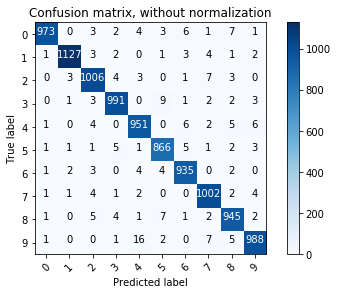

In [19]:
# Runs the algorithm for # epochs and displays the error loss at each epoch
total_batch = int(len(mnist.train.labels) / batch_size)
y_t_cm_arg = sess.run(tf.argmax(mnist.test.labels,1))
    
for epoch in range(epochs):
    avg_cost = 0
        
    for i in range(total_batch):
        batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
        _,c = sess.run([optimizer, cross_entropy], feed_dict={x: batch_x, y: batch_y})
            
        avg_cost += c / total_batch
        
    avg_cost_lst.append(avg_cost)
    print("Epoch:", (epoch + 1), "cost=", "{:.3f}".format(avg_cost))
    y_out_epoch = sess.run(y_output_arg, feed_dict={x: mnist.test.images, y: mnist.test.labels})
    calculate_error_rate(y_out_epoch,y_t_cm_arg)
#         print("Accuracy for Epoch:", (epoch + 1), "is ", sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}) )
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
y_out_cm_arg = sess.run(y_output_arg, feed_dict={x: mnist.test.images, y: mnist.test.labels})
print(y_out_cm_arg)
print(y_t_cm_arg)
cmf_val = confusion_matrix(y_out_cm_arg, y_t_cm_arg)
print(cmf_val)
plot_confusion_matrix(cmf_val, classes=class_names, title='Confusion matrix, without normalization')

In [20]:
# Stores Average Error cost in an array
avg_cost_lst

[0.66067484880035576,
 0.2365710242160341,
 0.1772020834819841,
 0.13940554662692276,
 0.1133969053338197,
 0.10027877523648464,
 0.084591137640686084,
 0.069220866006375753,
 0.05844858295241883,
 0.051663243848280145,
 0.04209838714111936,
 0.037424486004747459,
 0.030171211615670476,
 0.025149673793613058,
 0.020452143893714737,
 0.016387698055319061,
 0.012931002762422641,
 0.0084793983867116757,
 0.0053903318916722542,
 0.0044732861347835176]

In [21]:
# Arranges the Number of Epochs used 
x_plt = np.arange(1,epochs+1)

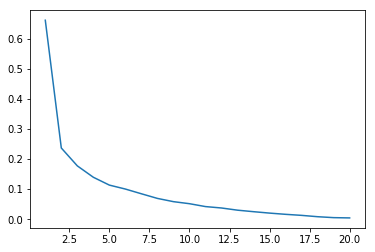

In [22]:
# Plots the Error Loss graph to show the reduction of error at each epoch or iteration
plt.plot(x_plt,avg_cost_lst)